Persiapan

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import splitfolders

**Mengunduh Dataset**

In [3]:
! chmod 600 /content/kaggle.json

In [4]:
! KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d guy007/nutrientdeficiencysymptomsinrice

 97% 962M/989M [00:04<00:00, 263MB/s]
100% 989M/989M [00:04<00:00, 215MB/s]


In [5]:
#Mengekstrak gambar
zip_file = zipfile.ZipFile('/content/nutrientdeficiencysymptomsinrice.zip')
zip_file.extractall('/content/nutrient-deficiency-detection')

In [6]:
#melakukan split data sebesar
#60% training dan 40% test
splitfolders.ratio('/content/nutrient-deficiency-detection/rice_plant_lacks_nutrients', output="/content/datasplit",seed=999, ratio=(.6, .4))

Copying files: 1156 files [00:05, 201.49 files/s]


In [7]:
base_dir = '/content/datasplit'
folder_train = '/content/datasplit/train'
folder_validation = '/content/datasplit/val'

In [8]:
print(os.listdir(folder_train))
print(os.listdir(folder_validation))

['Phosphorus(P)', 'Potassium(K)', 'Nitrogen(N)']
['Phosphorus(P)', 'Potassium(K)', 'Nitrogen(N)']


In [9]:
#Menghitung Jumlah pada Dataset
total_data = 0

# Iterasi semua file di dalam direktori
for root, dirs, files in os.walk(base_dir):
    total_data += len(files)

print("Jumlah total data:", total_data)

Jumlah total data: 1156


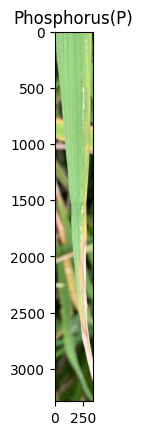

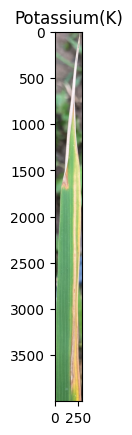

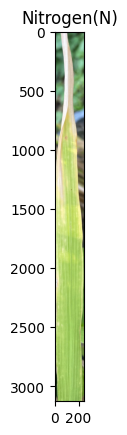

In [10]:
#Menampilkan gambar tiap kelas
for root, dirs, files in os.walk(folder_train):
    for dir_name in dirs:
        folder_path = os.path.join(root, dir_name)
        image_files = os.listdir(folder_path)
        if len(image_files) > 0:
            image_path = os.path.join(folder_path, image_files[0])
            image = mpimg.imread(image_path)
            plt.imshow(image)
            plt.title(dir_name)
            plt.show()

**DATA PREPARATION**

In [11]:
IMAGE_SIZE = (250,250)
BATCH_SIZE = 32
SEED = 999

In [12]:
# Menggunakan ImageDataGenerator untuk preprocessing
imagegenerator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)

In [13]:
# Image Data Generator pada Dataset
train_data = imagegenerator.flow_from_directory(
    folder_train,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

validation_data = imagegenerator.flow_from_directory(
    folder_validation,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 692 images belonging to 3 classes.
Found 464 images belonging to 3 classes.


In [14]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

**Model**

In [15]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

74836368/74836368 [==============================] - 0s 0us/step


In [16]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [17]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=10,
    validation_data = validation_data
)

Epoch 1/10
22/22 [==============================] - 499s 22s/step - loss: 1.1558 - accuracy: 0.4942 - val_loss: 0.7013 - val_accuracy: 0.6767
Epoch 2/10
22/22 [==============================] - 459s 21s/step - loss: 0.6665 - accuracy: 0.7066 - val_loss: 0.5072 - val_accuracy: 0.7888
Epoch 3/10
22/22 [==============================] - 457s 21s/step - loss: 0.5029 - accuracy: 0.7847 - val_loss: 0.3288 - val_accuracy: 0.8685
Epoch 4/10
22/22 [==============================] - 462s 22s/step - loss: 0.4863 - accuracy: 0.8179 - val_loss: 0.3000 - val_accuracy: 0.8772
Epoch 5/10
22/22 [==============================] - 456s 21s/step - loss: 0.4254 - accuracy: 0.8425 - val_loss: 0.2627 - val_accuracy: 0.8901
Epoch 6/10
22/22 [==============================] - 425s 20s/step - loss: 0.3194 - accuracy: 0.8743 - val_loss: 0.3279 - val_accuracy: 0.8664
Epoch 7/10
22/22 [==============================] - 422s 19s/step - loss: 0.3782 - accuracy: 0.8598 - val_loss: 0.3475 - val_accuracy: 0.8642
Epoch 

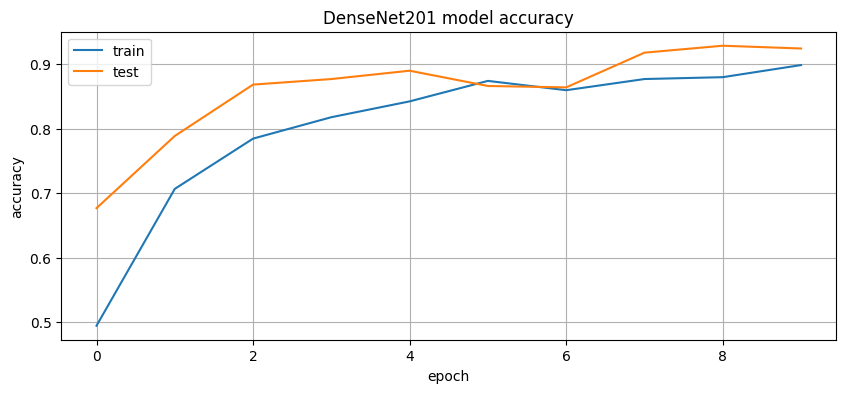

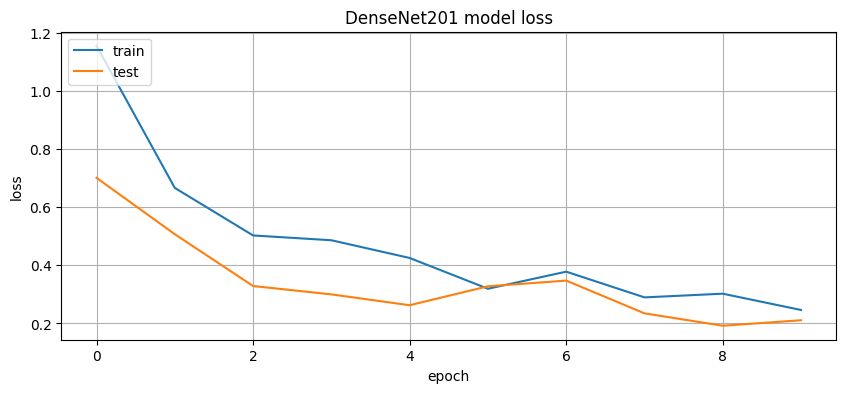

In [18]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Uji Coba**

In [19]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'Nitrogen(N)': 0, 'Phosphorus(P)': 1, 'Potassium(K)': 2}

Saving nit.jpg to nit.jpg
1/1 [==============================] - 5s 5s/step
nit.jpg
Nutrient Deficiency of Pottasium


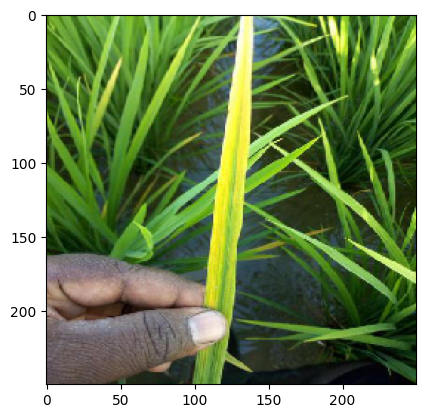

In [20]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from google.colab import files

%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  # Memprediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes == 0:
    print('Nutrient Deficiency of Nitrogen')
  elif classes == 1:
    print('Nutrient Deficiency of Phosporus')  
  else:
    print('Nutrient Deficiency of Pottasium')